Heatmaps erstellen

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

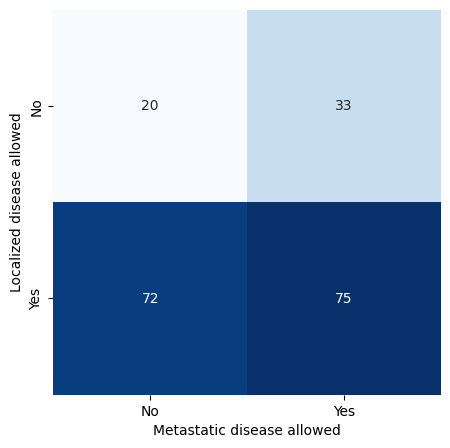

In [2]:
# Heatmap erstellen vom Datenset (von den Studien die untersucht werden)

# Datensatz importieren (literal eval braucht es damit die Listen in accept als listen auswertbar sind)
tabelle = pd.read_csv("C:/Users/Julia/Desktop/Masterarbeit/Auswertung/GPT5_high_temp100.csv", converters={'accept': literal_eval,'abstract_gpt-5-2025-08': literal_eval, 'full_text_gpt-5-2025-08': literal_eval})

#Dummie-Variabeln erstellen für die accept palte
tabelle1 = tabelle.join(pd.get_dummies(tabelle["accept"].explode()).groupby(level=0).sum())
#Dummie-Variabeln erstellen für die Abstract Labels
tabelle1 = tabelle1.join(pd.get_dummies(tabelle["abstract_gpt-5-2025-08"].explode(), prefix="ABSTRACT").groupby(level=0).sum())
#Dummie-Variabeln erstellen für die Fulltext Labels
tabelle1 = tabelle1.join(pd.get_dummies(tabelle["full_text_gpt-5-2025-08"].explode(), prefix="FULL_TEXT").groupby(level=0).sum())

# Heatmap mit Verteilung von Local und metastatic im dataset
fig = plt.figure(figsize=(5, 5))
LM_cross_tab = pd.crosstab(tabelle1['LOCAL'], tabelle1['METASTATIC'])

sns.heatmap(LM_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Metastatic disease allowed")
plt.ylabel("Localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])

# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("LM-Verteilung.png", dpi=300, bbox_inches="tight")

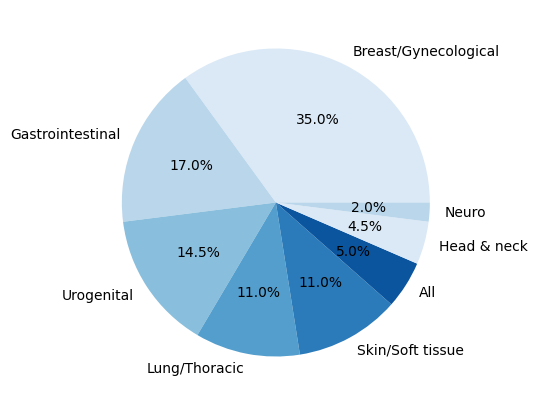

In [3]:
# Kuchendiagramm von der Tumorart der untersuchten Papers
fig = plt.figure(figsize=(5, 5))
sns.set_palette("Blues")
tabelle["family"].value_counts().plot.pie(autopct="%1.1f%%")
plt.ylabel("")
plt.show()

fig.savefig("Tumorarten.png", dpi=300, bbox_inches="tight")

In [ ]:
#Listen in  "ALL_Labeles" konvertieren

# Neue Spalte mit dem Baseline-Label (Dummiespalten werden oben schon gemacht
tabelle1.loc[
    (tabelle1["LOCAL"] == 1) & (tabelle1["METASTATIC"] == 0), "ALL_LABELS"
] = "Local_only"
tabelle1.loc[(tabelle1["LOCAL"] == 0) & (tabelle1["METASTATIC"] == 1), "ALL_LABELS"] = (
    "Metastatic_only"
)
tabelle1.loc[(tabelle1["LOCAL"] == 1) & (tabelle1["METASTATIC"] == 1), "ALL_LABELS"] = (
    "Both"
)
tabelle1.loc[(tabelle1["LOCAL"] == 0) & (tabelle1["METASTATIC"] == 0), "ALL_LABELS"] = (
    "Neither"
)


# Neue Spalte mit ABSTRACT_LABEL

tabelle1.loc[
    (tabelle1["ABSTRACT_LOCAL"] == 1) & (tabelle1["ABSTRACT_METASTATIC"] == 0), "ABSTRACT_ALL_LABELS"
] = "Local_only"
tabelle1.loc[(tabelle1["ABSTRACT_LOCAL"] == 0) & (tabelle1["ABSTRACT_METASTATIC"] == 1), "ABSTRACT_ALL_LABELS"] = (
    "Metastatic_only"
)
tabelle1.loc[(tabelle1["ABSTRACT_LOCAL"] == 1) & (tabelle1["ABSTRACT_METASTATIC"] == 1), "ABSTRACT_ALL_LABELS"] = (
    "Both"
)
tabelle1.loc[(tabelle1["ABSTRACT_LOCAL"] == 0) & (tabelle1["ABSTRACT_METASTATIC"] == 0), "ABSTRACT_ALL_LABELS"] = (
    "Neither"
)

# Neue Spalte mit FULL_TEXT_LABEL

tabelle1.loc[
    (tabelle1["FULL_TEXT_LOCAL"] == 1) & (tabelle1["FULL_TEXT_METASTATIC"] == 0), "FULL_TEXT_ALL_LABELS"
] = "Local_only"
tabelle1.loc[(tabelle1["FULL_TEXT_LOCAL"] == 0) & (tabelle1["FULL_TEXT_METASTATIC"] == 1), "FULL_TEXT_ALL_LABELS"] = (
    "Metastatic_only"
)
tabelle1.loc[(tabelle1["FULL_TEXT_LOCAL"] == 1) & (tabelle1["FULL_TEXT_METASTATIC"] == 1), "FULL_TEXT_ALL_LABELS"] = (
    "Both"
)
tabelle1.loc[(tabelle1["FULL_TEXT_LOCAL"] == 0) & (tabelle1["FULL_TEXT_METASTATIC"] == 0), "FULL_TEXT_ALL_LABELS"] = (
    "Neither"
)
tabelle1

In [5]:
#Funktion für 4x4 Heatmaps
def small_confusion_matrix(Label, Text): #labels als Strings und in Grossbuchstaben einfügen
    if Label == "LOCAL":
        x = "localized"
    else: 
        x = "metastatic"

    # Create confusion matrix of predicted and actual values for LOCAL
    confusion_matrix = pd.crosstab(tabelle1[Label], tabelle1[f"{Text}_{Label}"])

    # Plot the confusion matrix
    fig = plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
    plt.xlabel(f"Predicted {x} disease allowed")
    plt.ylabel(f"Actual {x} disease allowed")
    plt.xticks([0.5, 1.5], ["No", "Yes"])
    plt.yticks([0.5, 1.5], ["No", "Yes"])
    # Remove the colorbar but keep the width of the heatmap
    plt.gca().collections[0].colorbar.remove()
    plt.show()
    fig.savefig(f"confusion_matrix_{Label}_{Text}.png", dpi=300, bbox_inches="tight")

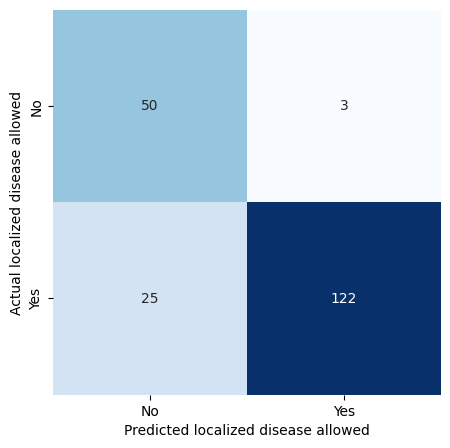

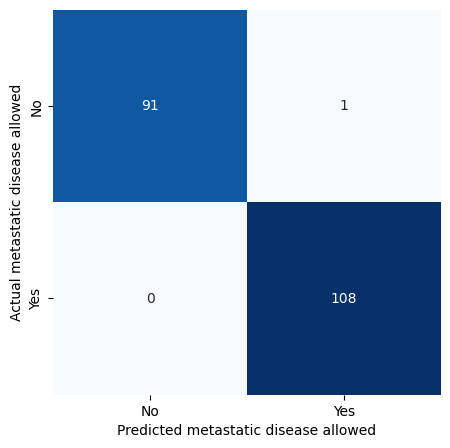

In [6]:
#Confusionmatices für Abstract erstellen
small_confusion_matrix("LOCAL", "ABSTRACT")
small_confusion_matrix("METASTATIC", "ABSTRACT")

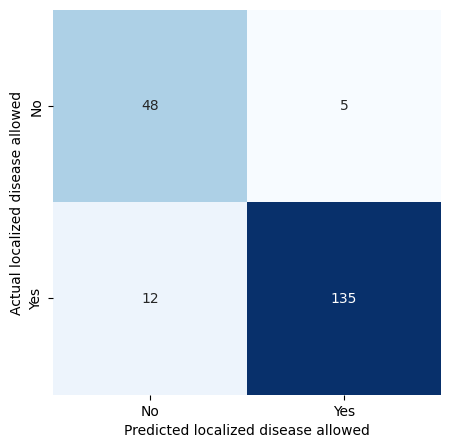

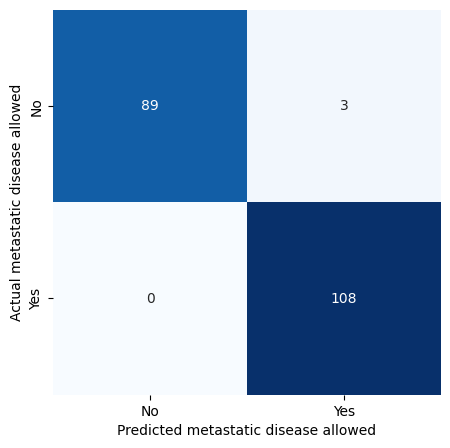

In [7]:
#Confusionmatices für Fulltext erstellen
small_confusion_matrix("LOCAL", "FULL_TEXT")
small_confusion_matrix("METASTATIC", "FULL_TEXT")

In [8]:
#Statistische Auswertung, accuracy, precision, recall, f1-Score
def statistics(Label, Text): #labels als Strings und in Grossbuchstaben einfügen
    # Calculate the accuracy of the ML prediction for LOCAL
    accuracy = (
        np.sum(tabelle1[Label] == tabelle1[f"{Text}_{Label}"])
        / tabelle1.shape[0]
    )
    # Estimate the 95 % confidence interval for the accuracy
    accuracy_std = np.sqrt(
        accuracy * (1 - accuracy) / tabelle1.shape[0]
    )
    accuracy_CI = 1.96 * accuracy_std
    print(
        f"Accuracy of {Text} prediction for {Label}: {accuracy:.2f} (95% CI: {accuracy - accuracy_CI:.2f} - {accuracy + accuracy_CI:.2f})"
    )
    # Calculate the precision of the ML prediction for LOCAL
    precision = (
        np.sum(
            (tabelle1[Label] == 1) & (tabelle1[f"{Text}_{Label}"] == 1)
        )
        / np.sum(tabelle1[f"{Text}_{Label}"] == 1)
    )
    # Estimate the 95 % confidence interval for the precision
    precision_std = np.sqrt(
        precision * (1 - precision) / np.sum(tabelle1[f"{Text}_{Label}"] == 1)
    )
    precision_CI = 1.96 * precision_std
    print(f"Precision of {Text} prediction for {Label}: {precision:.2f} (95% CI: {precision - precision_CI:.2f} - {precision + precision_CI:.2f})")
    # Calculate the recall
    recall = (
        np.sum(
            (tabelle1[Label] == 1) & (tabelle1[f"{Text}_{Label}"] == 1)
        )
        / np.sum(tabelle1[Label] == 1)
    )
    # Estimate the 95 % confidence interval for the recall
    recall_std = np.sqrt(
        recall * (1 - recall) / np.sum(tabelle1[Label] == 1)
    )
    recall_CI = 1.96 * recall_std
    print(
        f"Recall of {Text} prediction for {Label}: {recall:.2f} (95% CI: {recall - recall_CI:.2f} - {recall + recall_CI:.2f})"
    )
    # Calculate the F1 score 
    f1 = 2 * precision * recall / (precision + recall)
    # Estimate the 95 % confidence interval for the F1 score
    f1_std = np.sqrt(
        f1 * (1 - f1) / tabelle1.shape[0]
    )
    f1_CI = 1.96 * f1_std
    print(f"F1 score of {Text} prediction for {Label}: {f1:.2f} (95% CI: {f1 - f1_CI:.2f} - {f1 + f1_CI:.2f})")


In [9]:
statistics("LOCAL","ABSTRACT")

Accuracy of ABSTRACT prediction for LOCAL: 0.86 (95% CI: 0.81 - 0.91)
Precision of ABSTRACT prediction for LOCAL: 0.98 (95% CI: 0.95 - 1.00)
Recall of ABSTRACT prediction for LOCAL: 0.83 (95% CI: 0.77 - 0.89)
F1 score of ABSTRACT prediction for LOCAL: 0.90 (95% CI: 0.85 - 0.94)


In [10]:
statistics("LOCAL","FULL_TEXT")

Accuracy of FULL_TEXT prediction for LOCAL: 0.92 (95% CI: 0.88 - 0.95)
Precision of FULL_TEXT prediction for LOCAL: 0.96 (95% CI: 0.93 - 1.00)
Recall of FULL_TEXT prediction for LOCAL: 0.92 (95% CI: 0.87 - 0.96)
F1 score of FULL_TEXT prediction for LOCAL: 0.94 (95% CI: 0.91 - 0.97)


In [11]:
statistics("METASTATIC","ABSTRACT")

Accuracy of ABSTRACT prediction for METASTATIC: 0.99 (95% CI: 0.99 - 1.00)
Precision of ABSTRACT prediction for METASTATIC: 0.99 (95% CI: 0.97 - 1.01)
Recall of ABSTRACT prediction for METASTATIC: 1.00 (95% CI: 1.00 - 1.00)
F1 score of ABSTRACT prediction for METASTATIC: 1.00 (95% CI: 0.99 - 1.00)


In [12]:
statistics("METASTATIC","FULL_TEXT")

Accuracy of FULL_TEXT prediction for METASTATIC: 0.98 (95% CI: 0.97 - 1.00)
Precision of FULL_TEXT prediction for METASTATIC: 0.97 (95% CI: 0.94 - 1.00)
Recall of FULL_TEXT prediction for METASTATIC: 1.00 (95% CI: 1.00 - 1.00)
F1 score of FULL_TEXT prediction for METASTATIC: 0.99 (95% CI: 0.97 - 1.00)


In [14]:
def McNemar_accuracy(Label): # Label = "LOCAL", "METASTATIC", "ALL_LABELS"
    print ("P-Wert-Berechnung mittels McNemar für die Accuracy von", Label)
    a = np.sum(
        (tabelle1[Label] == tabelle1[f"ABSTRACT_{Label}"]) &
        (tabelle1[Label] == tabelle1[f"FULL_TEXT_{Label}"])
    ) #A und FT richtig
    print("a =", a)

    b = np.sum(
        (tabelle1[Label] == tabelle1[f"ABSTRACT_{Label}"]) &
        (tabelle1[Label] != tabelle1[f"FULL_TEXT_{Label}"])
    ) #A richtig und FT Falsch
    print("b =", b)

    c = np.sum(
        (tabelle1[Label] != tabelle1[f"ABSTRACT_{Label}"]) &
        (tabelle1[Label] == tabelle1[f"FULL_TEXT_{Label}"])
    ) #A falsch und FT richtig
    print("c =", c)

    d = np.sum(
        (tabelle1[Label] != tabelle1[f"ABSTRACT_{Label}"]) &
        (tabelle1[Label] != tabelle1[f"FULL_TEXT_{Label}"])
    ) #A falsch und FT falsch
    print("d =", d)

    #McNemar ausführung
    Vierertabelle = [[a, b],
                     [c, d]]

    P_accuracy_Label = mcnemar(Vierertabelle, exact=True)
    print("Chi-Quadrat=", P_accuracy_Label.statistic, ", P-Wert = ", P_accuracy_Label.pvalue)
    

In [15]:
McNemar_accuracy("LOCAL")

P-Wert-Berechnung mittels McNemar für die Accuracy von LOCAL
a = 167
b = 5
c = 16
d = 12
Chi-Quadrat= 5.0 , P-Wert =  0.02660369873046875


In [16]:
McNemar_accuracy("METASTATIC")

P-Wert-Berechnung mittels McNemar für die Accuracy von METASTATIC
a = 197
b = 2
c = 0
d = 1
Chi-Quadrat= 0.0 , P-Wert =  0.5


In [17]:
McNemar_accuracy("ALL_LABELS")

P-Wert-Berechnung mittels McNemar für die Accuracy von ALL_LABELS
a = 167
b = 5
c = 16
d = 12
Chi-Quadrat= 5.0 , P-Wert =  0.02660369873046875


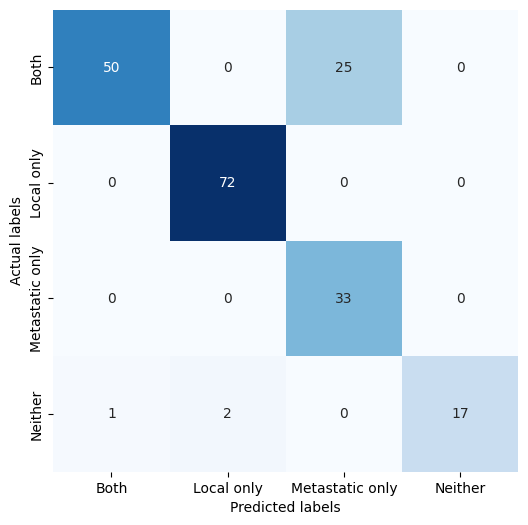

In [22]:
# Create the confusion matrix of predicted and actual values for combined labels
confusion_matrix = pd.crosstab(
    tabelle1["ALL_LABELS"], tabelle1["ABSTRACT_ALL_LABELS"]
)

# Add a column called "Neither" and fill it with zeros if it does not exist
if "Neither" not in confusion_matrix.columns:
    confusion_matrix["Neither"] = 0
    

# Plot the confusion matrix
fig = plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")


plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("confusion_matrix_all_labels_ABSTRACT.png", dpi=300, bbox_inches="tight")

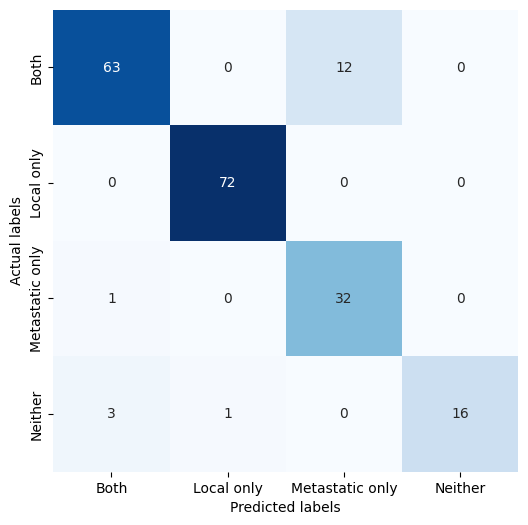

In [23]:
# Create the confusion matrix of predicted and actual values for combined labels
confusion_matrix = pd.crosstab(
    tabelle1["ALL_LABELS"], tabelle1["FULL_TEXT_ALL_LABELS"]
)

# Add a column called "Neither" and fill it with zeros if it does not exist
if "Neither" not in confusion_matrix.columns:
    confusion_matrix["Neither"] = 0
    

# Plot the confusion matrix
fig = plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")


plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig("confusion_matrix_all_labels_FULL_TEXT.png", dpi=300, bbox_inches="tight")

In [29]:
#Statistics für all Labels

# Calculate the accuracy for all labels ABSTRACT
accuracy_combined_abstract = (
    np.sum(tabelle1["ALL_LABELS"] == tabelle1["ABSTRACT_ALL_LABELS"])
    / tabelle1.shape[0]
)
# Estimate the 95 % confidence interval for the accuracy
accuracy_combined_abstract_std = np.sqrt(
    accuracy_combined_abstract * (1 - accuracy_combined_abstract) / tabelle1.shape[0]
)

accuracy_combined_abstract_CI = 1.96 * accuracy_combined_abstract_std
print(
    f"Accuracy of all labels with ABSTRACT: {accuracy_combined_abstract:.2f} (95% CI: {accuracy_combined_abstract - accuracy_combined_abstract_CI:.2f} - {accuracy_combined_abstract + accuracy_combined_abstract_CI:.2f})"
)
print("##############################################")

# Calculate the accuracy for all labels FULL_TEXT
accuracy_combined_fulltext = (
    np.sum(tabelle1["ALL_LABELS"] == tabelle1["FULL_TEXT_ALL_LABELS"])
    / tabelle1.shape[0]
)
# Estimate the 95 % confidence interval for the accuracy
accuracy_combined_fulltext_std = np.sqrt(
    accuracy_combined_fulltext * (1 - accuracy_combined_fulltext) / tabelle1.shape[0]
)

accuracy_combined_fulltext_CI = 1.96 * accuracy_combined_fulltext_std
print(
    f"Accuracy of all labels with FULL_TEXT: {accuracy_combined_fulltext:.2f} (95% CI: {accuracy_combined_fulltext - accuracy_combined_fulltext_CI:.2f} - {accuracy_combined_fulltext + accuracy_combined_fulltext_CI:.2f})"
)


    

Accuracy of all labels with ABSTRACT: 0.86 (95% CI: 0.81 - 0.91)
##############################################
Accuracy of all labels with FULL_TEXT: 0.92 (95% CI: 0.88 - 0.95)


In [31]:
def Precision_Recall_F1_ALL_LABELS(TEXT, AL):    
    # Calculate the precision
    precision = (
        np.sum(
            (tabelle1["ALL_LABELS"] == AL) & (tabelle1[f"{TEXT}_ALL_LABELS"] == AL)
        )
        / np.sum(tabelle1[f"{TEXT}_ALL_LABELS"] == AL)
    )

    # Estimate the 95 % confidence interval for the precision
    precision_std = np.sqrt(
        precision * (1 - precision) / np.sum(tabelle1[f"{TEXT}_ALL_LABELS"] == AL)
    )
    precision_CI = 1.96 * precision_std
    print(f"Precision for {AL} - {TEXT}: {precision:.2f} (95% CI: {precision - precision_CI:.2f} - {precision + precision_CI:.2f})")
    
    # Calculate the recall
    recall = (
        np.sum(
            (tabelle1["ALL_LABELS"] == AL) & (tabelle1[f"{TEXT}_ALL_LABELS"] == AL)
        )
        / np.sum(tabelle1["ALL_LABELS"] == AL)
    )

    # Estimate the 95 % confidence interval for the recall
    recall_std = np.sqrt(
        recall * (1 - recall) / np.sum(tabelle1["ALL_LABELS"] == AL)
    )
    recall_CI = 1.96 * recall_std
    print(
        f"Recall for {AL} - {TEXT}: {recall:.2f} (95% CI: {recall - recall_CI:.2f} - {recall + recall_CI:.2f})"
    )

    # Calculate the F1 score of the ML model for Both
    f1 = 2 * precision * recall / (precision + recall)

    # Estimate the 95 % confidence interval for the F1 score
    f1_std = np.sqrt(
        f1 * (1 - f1) / tabelle1.shape[0]
    )
    f1_CI = 1.96 * f1_std
    print(f"F1 score for {AL} - {TEXT}: {f1:.2f} (95% CI: {f1 - f1_CI:.2f} - {f1 + f1_CI:.2f})")
    print("##############################################")




In [32]:
Precision_Recall_F1_ALL_LABELS("ABSTRACT", "Both")
Precision_Recall_F1_ALL_LABELS("ABSTRACT", "Local_only")
Precision_Recall_F1_ALL_LABELS("ABSTRACT", "Metastatic_only")
Precision_Recall_F1_ALL_LABELS("ABSTRACT", "Neither")

Precision for Both - ABSTRACT: 0.98 (95% CI: 0.94 - 1.02)
Recall for Both - ABSTRACT: 0.67 (95% CI: 0.56 - 0.77)
F1 score for Both - ABSTRACT: 0.79 (95% CI: 0.74 - 0.85)
##############################################
Precision for Local_only - ABSTRACT: 0.97 (95% CI: 0.94 - 1.01)
Recall for Local_only - ABSTRACT: 1.00 (95% CI: 1.00 - 1.00)
F1 score for Local_only - ABSTRACT: 0.99 (95% CI: 0.97 - 1.00)
##############################################
Precision for Metastatic_only - ABSTRACT: 0.57 (95% CI: 0.44 - 0.70)
Recall for Metastatic_only - ABSTRACT: 1.00 (95% CI: 1.00 - 1.00)
F1 score for Metastatic_only - ABSTRACT: 0.73 (95% CI: 0.66 - 0.79)
##############################################
Precision for Neither - ABSTRACT: 1.00 (95% CI: 1.00 - 1.00)
Recall for Neither - ABSTRACT: 0.85 (95% CI: 0.69 - 1.01)
F1 score for Neither - ABSTRACT: 0.92 (95% CI: 0.88 - 0.96)
##############################################


In [33]:
Precision_Recall_F1_ALL_LABELS("FULL_TEXT", "Both")
Precision_Recall_F1_ALL_LABELS("FULL_TEXT", "Local_only")
Precision_Recall_F1_ALL_LABELS("FULL_TEXT", "Metastatic_only")
Precision_Recall_F1_ALL_LABELS("FULL_TEXT", "Neither")

Precision for Both - FULL_TEXT: 0.94 (95% CI: 0.88 - 1.00)
Recall for Both - FULL_TEXT: 0.84 (95% CI: 0.76 - 0.92)
F1 score for Both - FULL_TEXT: 0.89 (95% CI: 0.84 - 0.93)
##############################################
Precision for Local_only - FULL_TEXT: 0.99 (95% CI: 0.96 - 1.01)
Recall for Local_only - FULL_TEXT: 1.00 (95% CI: 1.00 - 1.00)
F1 score for Local_only - FULL_TEXT: 0.99 (95% CI: 0.98 - 1.00)
##############################################
Precision for Metastatic_only - FULL_TEXT: 0.73 (95% CI: 0.60 - 0.86)
Recall for Metastatic_only - FULL_TEXT: 0.97 (95% CI: 0.91 - 1.03)
F1 score for Metastatic_only - FULL_TEXT: 0.83 (95% CI: 0.78 - 0.88)
##############################################
Precision for Neither - FULL_TEXT: 1.00 (95% CI: 1.00 - 1.00)
Recall for Neither - FULL_TEXT: 0.80 (95% CI: 0.62 - 0.98)
F1 score for Neither - FULL_TEXT: 0.89 (95% CI: 0.85 - 0.93)
##############################################
